# 순환 신경망을 이용한 문장 생성 예제
## : Simple RNN, GRU, LSTM 활용

<br><br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; Simple RNN, GRU, LSTM 각 세 개의 문장 생성 모델을 학습하여 생성된 문장과 validation loss를 확인한다. 학습 데이터는 영문으로 작성된 자연어 문장으로, 175,986개의 문장과 28,581개의 단어로 구성된다. 데이터 분석 과정에서 85% 문장이 12개의 단어로 이루어져있으며, 단어는 대체로 15자 이하이며, 그 이상의 단어는 감탄사나 여러 단어가 합쳐진 것을 확인하였다. 따라서 전처리 과정에서 3개 이상, 12개 이하의 단어로 구성된 문장과 14자 이하의 글자 수로 된 단어만을 추출하였다. 토크나이저의 단어 사전은 12,000개로 설정하였다. Simple RNN, LSTM, GRU 모델 모두 500차원의 임베딩 레이어, 2,000개 유닛의 RNN 레이어, 20% 비율의 드롭아웃 레이어, 배치 정규화 레이어 순으로 설계하였다. 옵티마이저는 Adam을 사용하였으며, 학습 데이터 32개를 배치사이즈로 설정하고 각 모델 모두 동일하게 적용하였다. 각 모델을 학습한 결과 Simple RNN 모델에서는 epoch 4에서 validation loss가 2.9285였다. Simple RNN 학습 결과의 특이사항으로는 단어사전에 추가되지 못한 토큰인 &lt;unk>가 생성 문장에 자주 등장하였다. 또한, 해당 토큰이 주로 '명사' 자리에 위치하였다. GRU 모델에서는 validation loss가 epoch 4에서 2.2024였다. GRU 학습 결과의 특이사항으로는 LSTM에 비해 적은 파라미터를 이용함에도 불구하고 좋은 결과를 제시해 주었다. LSTM 모델에서는 epoch 4에서 2.1809로 세 모델 중 가장 낮은 validationo loss를 획득하였다.
</span>

***

<br><br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 Simple RNN과 GRU, LSTM을 사용한 세 개의 문장생성 모델을 이용하여 validation loss와 문장생성 능력을 확인한다. RNN 즉, 재귀 신경망은 마르코프 체인과 함께 문장 생성 알고리즘 중 하나이며, 시간 순서를 가진 데이터를 다룰 수 있다는 특성을 가지고 있는 것으로 Simple RNN과 이를 개량한 LSTM, GRU가 있다[1]. 학습 데이터는 영문으로 된 자연어 문장으로 모델의 학습에 앞서 분석과 전처리 과정을 거친다. 이후 각 모델을 생성하여 validation loss와 생성된 문장을 확인하고자 한다. 다음은 본 예제 진행 순서를 제시한 것이다.
</span>

> 1. 학습 데이터 분석
> 2. 학습 데이터 정제 및 토크나이저 생성
> 3. 문장 생성 모델 생성
> 4. 모델 학습 및 생성 문장 확인

***

<br><br>

## 2. 학습 데이터 분석
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 먼저, 모델을 학습하기 위한 학습 데이터를 분석한다. 데이터는 텍스트 파일로 자연어로 된 여러 문장으로 구성되어있다. 학습 데이터를 분석하기 위해 데이터 수와 같은 기본 적인 사항을 알아보고 이후, 데이터를 문장과 단어 중심으로 살펴본다. 특히, 문장을 구성하고 있는 단어의 개수와 단어의 사용 빈도, 단어의 글자 개수 등을 파악하여 이후 전처리 시, 적절한 데이터로 정제과정을 거친다.
</span>

***

#### 라이브러리 호출 및 학습 데이터 불러오기

In [1]:
#라이브러리 호출
import re   #문자열 정규식
import os   #디렉토리 관리
import glob   #디렉토리 관리(2)
import nltk   #자연어 처리
import tensorflow as tf   #텐서관리
import matplotlib.pyplot as plt   #데이터 시각화

In [2]:
txt_file_path = "./lyricist_ex4/data/lyrics/*"
txt_list = glob.glob(txt_file_path)

raw_corpus = []
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

<br>

#### 문장 단위 전처리
***
+ 데이터 분석에 앞서, 비어있는 문장이나 특수기호 등의 불필요한 요소를 제거하는 과정이다.
+ 정규식을 사용한 문장 단위 전처리는 김윤 박사의 'CNN_sentence'의 코드를 사용하였다.
***

In [3]:
#단어 단위 분할 함수+++++++++++++++++++++++++++++++
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    #코드 수정==========================
    string = re.sub(r"[^A-Za-z!?\']", " ", string)
    string = re.sub(r'[" "]+', " ", string)
    #End================================
    
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    
    #코드 수정==========================
    string = re.sub(r",", " ", string) 
    string = re.sub(r"\(", " ", string) 
    string = re.sub(r"\)", " ", string) 
    #End================================
    return string.strip() if TREC else string.strip().lower()
#"CNN_sentence", Kim Yoon, accessed Oct, 8, 2021, https://github.com/yoonkim/CNN_sentence
#End++++++++++++++++++++++++++++++++++++++++++++++++++


#문장별로 정제하기===========================
corpus_sample = [clean_str(sentence) for sentence in raw_corpus if len(sentence) != 0]
#End=========================================


print("*" * 50, end="\n\n")
print(raw_corpus[3], "\n\n" + "↓" * 30 + "\n\n", corpus_sample[3])
print("\n" + "*" * 50)

**************************************************

I can't get no relief Business men, they drink my wine 

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

 i ca n't get no relief business men they drink my wine

**************************************************


#### clean_str() 코드 출처
***
+ "CNN_sentence", Kim Yoon, accessed Oct, 8, 2021, https://github.com/yoonkim/CNN_sentence
***

<br>

### 2.1. 문장 중심 데이터 분석
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 데이터는 총 175,986개의 영어 문장으로 이루어져있다. 또한, 85%의 문장이 12개 이하의 단어로 이루어져있으며, 가장 많은 단어 로 이루어져 있는 문장의 단어 수는 326개이다. 1개의 단어로 이루어져있는 데이터도 존재한다. 이는 전처리 과정 시 정제할 필요가 있다. Fig. 1은 문장별 단어 수를 보여준다. 
</span>

***

#### 데이터 기본 정보
***
+ 데이터 문장의 일부를 출력한다.
+ 문장의 총 개수는 175,986개이다.
***

In [4]:
#데이터 일부 출력========
print("*" * 50)
for line in corpus_sample[10:15]:
    print(line, end="\n\n")
print("*" * 50)
#End======================

#data_len=================
print("\n*sentence num:", len(corpus_sample), end="\n\n")

**************************************************
who feel that life is but a joke

but uh but you and i we 've been through that

and this is not our fate

so let us stop talkin' falsely now

the hour 's getting late hey all along the watchtower

**************************************************

*sentence num: 175986



<br>

#### 문장별 단어 수 확인
***
+ 문장의 단어 최대 개수는 326개, 최소 개수는 1개이다.
+ 약 85%의 문장은 12개 이하의 단어로 구성되어 있다.
***

**************************************************
minimum word: 1
maximum word: 326
85% word: 12
**************************************************


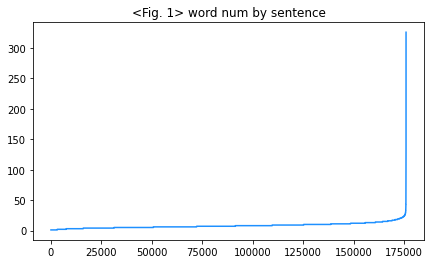

In [5]:
sentence_len = [len(sentence.split(" ")) for sentence in corpus_sample]
sentence_len.sort()


cut_size = int(len(sentence_len) * 0.85)
print("*" * 50)
print("minimum word:", sentence_len[0])
print("maximum word:", sentence_len[-1])
print("85% word:", sentence_len[cut_size])
print("*" * 50)

# #14개 이하 단어로 구성된 문장으로 정제
# corpus = [sentence for sentence in corpus if len(sentence.split(" ")) < 15]


#시각화==========================
plt.figure(figsize=(7, 4))
plt.title("<Fig. 1> word num by sentence")
plt.plot(sentence_len, color="#1e90ff")
plt.show()

#End=================================

<br>

#### 하나의 단어로 이루어진 문장
***
+ 한 단어로 이루어진 데이터는 문장이 아닐 가능성이 크다. 따라서 이후의 전처리 과정에서 제외할 필요가 있다.
+ 한 단어로 이루어진 데이터는 830개 이며, 아래는 한 단어로 이루어진 데이터 일부를 보여준다.
***

In [6]:
one_word_sentence = {sentence for sentence in corpus_sample if len(sentence.split(" ")) == 1}

print("*" * 50)
for line in list(one_word_sentence)[10:15]:
    print(line, end="\n\n")
print("*" * 50)

print("\n*one word sentence num:", len(one_word_sentence))

**************************************************
everything

temptation

andrew

tremble

super

**************************************************

*one word sentence num: 830


<br>

### 2.2. 단어 중심 데이터 분석
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 토큰 단위가 되는 단어를 중심으로 데이터를 분석한다. 데이터에서 단어가 전체적으로 사용된 빈도와 단어의 길이 즉, 글자 개수를 살펴본다. 데이터에서 사용된 단어는 총 28,581개 이다. 데이터에서 가장 많이 사용된 단어는 'i', 'the' 'you' 순으로 약 50,000회 정도 사용되었다. Fig. 2는 데이터에서 단어가 사용된 빈도를 보여준다. 또한 단어의 글자 개수는 약 1 ~ 35개이다. 하지만 글자 수가 15개 이상의 단어는 대체로 'owowowowowowowahhhh', 'yeahyeaheyeahhh' 등과 같이 감탄사 혹은 띄어쓰기가 되지 않은 단어의 빈도가 높다. 따라서 이러한 점을 고려하여, 이후 전처리 시 제외 작업을 할 필요가 있다. Fig. 3은 단어 별 글자 개수를 보여준다.
</span>

***

#### 단어 사용량
***
+ 총 단어 개수는 28,581개이다.
+ 사용 빈도가 높은 단어는 'i', 'the', 'you', 'and', 'a' 순이다.
***

**************************************************
*word num: 28581
**************************************************


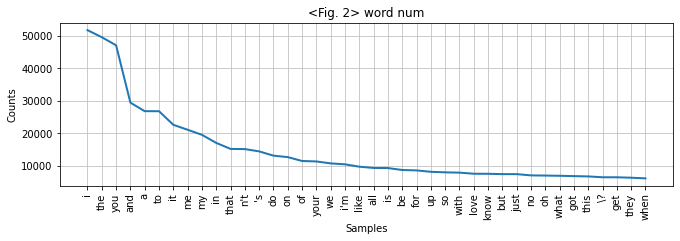

In [7]:
word_list_dup = [word for sentence in corpus_sample for word in sentence.split(" ")]
word_list = {word for word in word_list_dup}
nltk_text = nltk.Text(word_list_dup)

print("*" * 50)
print("*word num:", len(word_list))
print("*" * 50)


plt.figure(figsize=(11, 3))
plt.title("<Fig. 2> word num")
nltk_text.plot(40)
plt.show()

<br>

#### 단어별 글자 개수
***
+ 대부분의 단어는 1 ~ 15개 사이의 글자로 이루어져있다.
+ 그 이상의 단어는 감탄사나 띄어쓰기 하지 않은 단어로 이루어져있다.
***

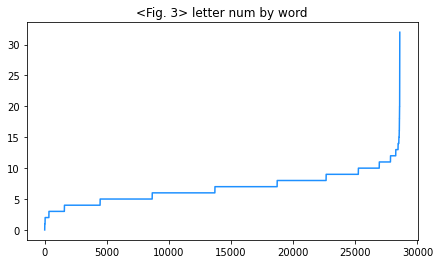

In [8]:
word_len = [len(word) for word in word_list]
word_len.sort()

#시각화==========================
plt.figure(figsize=(7, 4))
plt.title("<Fig. 3> letter num by word")
plt.plot(word_len, color="#1e90ff")
plt.show()
#End=================================

In [9]:
word_over_ten = [word for word in word_list if len(word) >= 15]

print("*" * 50)
for word in word_over_ten[:10]:
    print(word, end="\n\n")
print("*" * 50)

**************************************************
rollercoastered

purplelectricity

yeahyeaheyeahhh

bedfordstuyvesant

californication

contradictionary

straightforward

fourfiveseconds

responsibilities

owwooooeeeeioioeeeee

**************************************************


<br><br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 앞서 학습 데이터로 사용될 데이터를 분석하였다. 그 결과, 85%의 문장이 단어 12개로 이루어져 있음을 확인하였다. 또한, 한 개의 단어로 이루어진 데이터는 대부분 문장이 아님을 확인하였다. 데이터에 사용된 단어는 28,581개이다. 단어는 약 1 ~ 35개의 글자로 되어있다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 이러한 분석을 바탕으로, 데이터 전처리는 다음과 같은 작업을 수행하고자 한다. 단어가 2 ~ 12개로 이루어진 문장만을 데이터로 사용한다. 글자 수가 14개 이상인 단어를 포함한 문장은 제외한다. 전처리 과정을 거친 데이터는 총 147,864개의 문장과 25,937개의 단어로 구성된다.
</span><br><br>

***

In [10]:
sample_corpus = None
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0: continue;   #길이가 0인 문장
    if sentence[-1] == ":": continue;   #문장의 끝이 ':'인 문장

    new_sentence = clean_str(sentence, TREC=False)

    if len(new_sentence.split(" ")) < 3: continue;   #단어가 2개 이하인 문장 제외
    if len(new_sentence.split(" ")) > 12: continue;   #토큰이 15개 이상인 문장
    
    #단어 중심===========
    letter_num_TF = True
    for word in new_sentence.split(" "):
        if len(word) > 14:   #글자 수 15개 이상 단어 제외
            letter_num_TF = False
            break
    if not letter_num_TF: continue
    #End=================
        
    new_sentence = "<start> " + new_sentence + " <end>"
    corpus.append(new_sentence)

<br>

#### 정제 데이터 정보
***
+ &lt;start>와 &lt;end> 토큰을 추가한 것을 확인할 수 있다.
+ 총 문장 수는 147,864개, 단어 수는 25,937개 이다.
***

In [11]:
word_list = {word for sentence in corpus for word in sentence.split(" ")}


#데이터 일부 출력========
print("*" * 50)
for line in corpus[10:15]:
    print(line, end="\n\n")
print("*" * 50)
#End======================


print("\n*sentence num:", len(corpus))
print("*word num:", len(word_list))

**************************************************
<start> who feel that life is but a joke <end>

<start> but uh but you and i we 've been through that <end>

<start> and this is not our fate <end>

<start> so let us stop talkin' falsely now <end>

<start> the hour 's getting late hey all along the watchtower <end>

**************************************************

*sentence num: 147864
*word num: 25937


<br>

#### 데이터 토큰화
***
+ 12,000개의 단어사전을 가진 토크나이저를 생성한다.
+ 문장은 뒷 부분에 패딩을 추가한다.
***

In [12]:
#토크나이즈 함수======================================
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        oov_token="<unk>",   #포함되지 못한 단어는 "<unk>"로 처리
        filters=' '   #전처리되었으므로 제외
    )
    
    tokenizer.fit_on_texts(corpus)   #매개변수로 토크나이저 내부 단어장 생성
    tensor = tokenizer.texts_to_sequences(corpus)   #매개변수 Tensor로 변환
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding="post", maxlen = 15)
    return tensor, tokenizer
#End====================================================


tensor, tokenizer = tokenize(corpus)

print("*tensor shape:", tensor.shape)
print("\n*one_sample:", tensor[:1])

print("\n" + "*" * 50)
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    if idx >= 8: break
print("*" * 50)

*tensor shape: (147864, 15)

*one_sample: [[  2  58 268  26  89 528  20  82 754  86   3   0   0   0   0]]

**************************************************
1 : <unk>
2 : <start>
3 : <end>
4 : the
5 : i
6 : you
7 : and
8 : a
**************************************************


<br>

#### 데이터셋 생성하기
***
+ train_test_split으로 데이터를 분리한 후, from_tensor_slices를 이용하여 데이터셋을 생성한다.
+ 데이터셋 배치사이즈는 32로 설정한다.
***

In [13]:
#학습데이터와 정답 데이터 분리하기
from sklearn.model_selection import train_test_split
src_input = tensor[:, :-1]   #마지막 토큰을 잘라내 소스문장 생성 => x_data
tgt_input = tensor[:, 1:]   #첫번째 idx인 <start>를 잘라내기 => target_data

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 2)

#텐서플로 데이터셋으로 만들기==============
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))   #tensor를 dataset으로 변환
# dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#End=======================================

print("\n" + "*" * 50)
print("Source Train:", enc_train.shape)
print("Source val Train:", enc_val.shape)

print("\nTarget Train:", dec_train.shape)
print("Target val Train:", dec_val.shape)
print("*" * 50)


**************************************************
Source Train: (118291, 14)
Source val Train: (29573, 14)

Target Train: (118291, 14)
Target val Train: (29573, 14)
**************************************************


<br><br>

## 4. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 전처리를 거친 데이터를 바탕으로 모델을 학습 한다. 'Simple RNN', 'GRU', 'LSTM'에 대한 각 모델을 적용하여 학습을 진행한다. 각 모델은 임베딩 레이어, RNN 레이어, 0.2 비율의 드롭아웃 레이어, 배치정규화 레이어, 출력 레이어 순으로 설계하였으며, RNN 레이어의 유닛 수는 2,000개로 모두 동일하게 적용하였다. 또한, 임베딩 사이즈는 500을 적용하였다.
</span><br><br>

<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; 옵티마이저로 Adam을 사용하였으며, 배치 사이즈를 32개로 설정하였다. 학습 epoch는 4로 설정하였다. 또한, 매 epoch 마다 'i', 'you', 'love'를 문장의 시작 단어로 입력하여 생성되는 문장을 확인하고자 한다.
</span>

***

#### 모델 생성 및 콜백, 문장 예측 함수
***
+ 자주 사용되는 모델 생성과 콜백, 문장 예측, 모델 학습 기능을 클래스 및 함수화하였다.
+ 콜백 함수의 경우 모델 학습 시 매 epoch가 종료될 때, 문장 생성 예시를 출력한다.
***

In [14]:
#모델 생성 클래스=================================
class TextGenerator(tf.keras.Model):
    def __init__(
            self,
            model_type, #"LSTM", "GRU", "RNN"
            vocab_size,   #단어사전 크기
        ):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, 500)
        
        if model_type == "LSTM":
            self.rnn_1 = tf.keras.layers.LSTM(2000, return_sequences=True)
        elif model_type == "GRU":
            self.rnn_1 = tf.keras.layers.GRU(2000, return_sequences=True)
        else:
            self.rnn_1 = tf.keras.layers.SimpleRNN(2000, return_sequences=True, activation="tanh")
            
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.2)
        
        self.batnorm_1 = tf.keras.layers.BatchNormalization()
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.dropout_1(out)
        
        out = self.batnorm_1(out)
        out = self.linear(out)
        
        return out
#End==============================================
    
    
#문장 예측 함수====================================
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        test_tensor = tf.concat(
            [test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1
        )
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    return generated
#End==============================================


#콜백 함수========================================
def train_model(epoch, logs):
    print("\n\n" + "*" * 25)
    words = ["i", "you", "love"]
    for init_word in words:
        sentence = generate_text(model, tokenizer, "<start> " + init_word, 15)
        print(sentence, end="\n\n")
    print("*" * 25)
    
testmodelcb = tf.keras.callbacks.LambdaCallback(on_epoch_end=train_model)
#End==============================================


#컴파일 및 학습 함수==============================
def compile_fit(model, callback_func):
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )

    model.compile(loss=loss, optimizer=optimizer)

    hist = model.fit(
        enc_train, dec_train, 
        epochs=4,
        batch_size=32,
        validation_data=(enc_val, dec_val),
        shuffle=True,
        callbacks=[callback_func],
        verbose=1
    )
    return None
#End==============================================

<br>

#### input size 설정용 샘플 데이터
***
+ 모델의 입력 사이즈 설정을 위한 샘플 데이터 추출 과정
***

In [15]:
for src_sample, _ in dataset.take(1): break   #dataset으로부터 하나의 데이터 받아오기

<br>

### 4.1 Simple RNN
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Simple RNN은 순환 신경망의 기초적인 레이어이다. 과거에 대한 정보를 지속적으로 전달하여 시계열 등의 문제에 사용된다. Simple RNN의 경우 입력 데이터가 길어질수록 '장기의존성' 문제로 인해 성능이 저하되는 단점이 존재한다. 본 예제에서는 2,000개의 유닛을 가진 Simple RNN 레이어를 사용하였다. 또한, 활성화 함수로 'tanh'를 사용하였다.
</span>

***

In [16]:
model = TextGenerator(
    "SimpleRNN",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6000500   
_________________________________________________________________
simple_rnn (SimpleRNN)       multiple                  5002000   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  8000      
_________________________________________________________________
dense (Dense)                multiple                  24014001  
Total params: 35,024,501
Trainable params: 35,020,501
Non-trainable params: 4,000
_________________________________________________________________


<br>

#### 모델 학습 및 문장생성
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Simple RNN 모델의 학습 결과, epoch 4 일 때 validation loss가 2.9285로 성능이 가장 좋았다. Simple RNN 모델의 특징은 단어 사전에 등록되지 못한 토큰인 &lt;unk>가 자주 사용된 다는 것이다. 또한, 해당 토큰이 주로 명사 부분에 사용되는 것을 확인할 수 있다. 다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, Simple RNN 모델이 생성한 문장을 제시한 것이다.
</span><br><br>


> ___I'll be a &lt;unk>___...(ep 2)
>    
> ___You're gonna be a &lt;unk>___...(ep 4)
>    
> ___Love you want to be___...(ep 2)

***

In [17]:
compile_fit(model, testmodelcb)

Epoch 1/4
3697/3697 [==============================] - 407s 110ms/step - loss: 3.7402 - val_loss: 3.0707


*************************
<start> i know i know you <end> 

<start> you 're a <unk> <end> 

<start> love you 're a <unk> <end> 

*************************
Epoch 2/4
3697/3697 [==============================] - 405s 110ms/step - loss: 3.0607 - val_loss: 2.9953


*************************
<start> i 'll be a <unk> <end> 

<start> you 're the <unk> <end> 

<start> love you want to be <end> 

*************************
Epoch 3/4
3697/3697 [==============================] - 405s 110ms/step - loss: 2.9774 - val_loss: 2.9599


*************************
<start> i 'll be a <unk> <end> 

<start> you 're gonna be a <unk> <end> 

<start> love you know i do n't know <end> 

*************************
Epoch 4/4
3697/3697 [==============================] - 405s 109ms/step - loss: 2.9326 - val_loss: 2.9285


*************************
<start> i 'll be a <unk> <end> 

<start> you 're gonna be a <unk> 

<br>

### 4.2 GRU
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; GRU는 RNN의 '장기의존성'에 관한 논문을 제시한 '요슈아 벤지오' 교수의 제자인 뉴욕대학교 '조경현' 교수 등이 제안한 구조이다[2]. LSTM과 비슷한 기능을 하지만 구조가 간단하여 파라미터 수가 LSTM에 비해 적으며 특정 문제에서는 LSTM에 비해 좋은 성능을 보이기도 한다.
</span>

***

In [18]:
model = TextGenerator(
    "GRU",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6000500   
_________________________________________________________________
gru (GRU)                    multiple                  15012000  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  8000      
_________________________________________________________________
dense_1 (Dense)              multiple                  24014001  
Total params: 45,034,501
Trainable params: 45,030,501
Non-trainable params: 4,000
_________________________________________________________________


<br>

#### 모델 학습 및 문장생성
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; GRU 모델의 학습 결과, epoch 4 일 때 validation loss가 2.2024로 성능이 가장 좋았다. 하지만 생성한 문장은 오히려 epoch 3의 경우가 더 명확하고 직관적이다. 다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, GRU 모델이 생성한 문장을 제시한 것이다.
</span><br><br>


> ___I've got a lot of brains___...(ep 1)
>    
> ___You're the only one i want___...(ep 3)
>    
> ___Love me when you 're down___...(ep 2)

***

In [19]:
compile_fit(model, testmodelcb)

Epoch 1/4
3697/3697 [==============================] - 424s 114ms/step - loss: 3.0878 - val_loss: 2.5473


*************************
<start> i 've got a lot of brains <end> 

<start> you 're the only thing that 's right <end> 

<start> love me love me <end> 

*************************
Epoch 2/4
3697/3697 [==============================] - 421s 114ms/step - loss: 2.3080 - val_loss: 2.3088


*************************
<start> i 'll be there to you <end> 

<start> you know i ca n't stop <end> 

<start> love me when you 're down <end> 

*************************
Epoch 3/4
3697/3697 [==============================] - 423s 114ms/step - loss: 1.8570 - val_loss: 2.2064


*************************
<start> i do n't know what to do <end> 

<start> you 're the only one i want <end> 

<start> love is a feeling <end> 

*************************
Epoch 4/4
3697/3697 [==============================] - 421s 114ms/step - loss: 1.5624 - val_loss: 2.2024


*************************
<start> i know you 're no

<br>

### 4.3 LSTM
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; LSTM은 Simple RNN의 장기의존성 문제를 해결하기 위해 제안된 것으로, 유닛 간 상태를 보존하여 전달하는 것으로 해당 문제를 해결하였다. 즉, 과거의 기억을 잊게 하고, 최근 기억을 많이 이용하게 하는 것이다[3]. 앞서 제시된 Simple RNN과 GRU에 비해 요구되는 파라미터 수가 큰 편이다.
</span>

***

In [16]:
model = TextGenerator(
    "LSTM",
    tokenizer.num_words + 1,   #tokenizer.num_words: 단어사전 사이즈 + <pad>
)

model(src_sample)   #해당 데이터를 넣어줌으로써 모델 input_size 설정
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6000500   
_________________________________________________________________
lstm (LSTM)                  multiple                  20008000  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  8000      
_________________________________________________________________
dense (Dense)                multiple                  24014001  
Total params: 50,030,501
Trainable params: 50,026,501
Non-trainable params: 4,000
_________________________________________________________________


<br>

#### 모델 학습 및 문장생성
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; LSTM 모델의 학습 결과, epoch 4 일 때 validation loss가 2.1890으로 성능이 가장 좋았다. 다음은 'I', 'You', 'Love'를 시작 단어로 주었을 때, LSTM 모델이 생성한 문장을 제시한 것이다.
</span><br><br>


> ___I know you 're smiling down on me___...(ep 4)
>    
> ___You know that i love you___...(ep 4)
>    
> ___Love is a beautiful thing___...(ep 4)


***

In [17]:
compile_fit(model, testmodelcb)

Epoch 1/4
3697/3697 [==============================] - 483s 130ms/step - loss: 3.1441 - val_loss: 2.6050


*************************
<start> i do n't wanna be a man <end> 

<start> you 're the one who you are <end> 

<start> love is a love <end> 

*************************
Epoch 2/4
3697/3697 [==============================] - 482s 130ms/step - loss: 2.3864 - val_loss: 2.3819


*************************
<start> i do n't know what to do <end> 

<start> you know i know you know <end> 

<start> love is a beautiful thing <end> 

*************************
Epoch 3/4
3697/3697 [==============================] - 481s 130ms/step - loss: 2.0068 - val_loss: 2.2461


*************************
<start> i know i know i know <end> 

<start> you 're the only one <end> 

<start> love is a woman <end> 

*************************
Epoch 4/4
3697/3697 [==============================] - 480s 130ms/step - loss: 1.6637 - val_loss: 2.1890


*************************
<start> i know you 're smiling down on me <en

<br><br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.5; font-family:Serif;">
    &nbsp; &nbsp; Simple RNN, GRU, LSTM을 사용한 문장생성 모델로부터 15 단어 이하로 구성된 문장을 출력하도록 하였다. validation loss가 가장 낮았던 모델은 LSTM을 사용한 모델이었으며, epoch 4일 때, 2.1890이었다. Simple RNN의 경우 장기의존문제로 인해 학습이 의도대로 이루어지지 않았으며, 단어 사전에 포함되지 못한 토큰을 자주 출력하였다. 또한, 해당 토큰을 명사 자리에 주로 사용한 것을 확인하였다. GRU의 경우 LSTM에 비해 validation loss가 높았지만, 그 차이는 미미했으며, 적은 파라미터를 사용하였음에도 불구하고 문장생성이 올바르게 이루어진것을 확인하였다. [표 1]은 각 모델의 validation loss와 생성 문장을 제시한 것이다.
</span><br><br><br>


|model|Best validation loss|sentence|
|:--------:|:--------:|:--------:|
|**Simple RNN**|2.9285(4)|Love you want to be.|
|**GRU**|2.2024(4)|Love me when you 're down.|
|**LSTM**|**2.1890(4)**|You know that i love you.|


[표 1] 모델별 validation loss와 생성 문장

***

#### 참고문헌
***
[1] 쿠지라 히코우즈쿠에, 『파이썬을 이용한 머신러닝, 딥러닝 실전 개발 입문』, 위키북스(2020), 337

[2] 김환희, 『시작하세요! 텐서플로 2.0 프로그래밍』, 위키북스(2020), 194

[3] 이다치 하루카, 『텐서플로로 시작하는 딥러닝 입문』, 위키북스(2019), 147
***

#### 형상관리
***
+ ver1
    + ver1_1: 초기버전
    + ver1_2: 모델 변경
    
    
+ ver2
    + ver2_1: 배치정규화 이용
    + ver2_2: 임베딩 사이즈 변경 및 레이어 축소
    
    
+ ver3
    + ver3_1: Simple RNN, GRU, LSTM 도입
    + ver3_2: callback 함수 도입


+ ver4
    + ver4_1: 마크다운 양식 및 내용 수정
***

##### 회고
***
본 예제를 진행하면서 겪은 난항은 다음과 같다.

&nbsp; &nbsp; 목표 성능인 validation accuracy 2.2 이하를 달성하기 위해 상당한 시행착오를 겪었다. 그 과정 속에서 상당히 중요한 통찰을 얻게 됐는데, 모델 개선이, 항상 무엇인가를 '추가'한다고 하여 이루어지지는 않는 다는 것이다. 성능 개선을 하고자 할 때, 대체로 모델에 더 추가하고자 하는 생각이 먼저 든다. 유닛 수를 늘리거나, 레이어를 더 추가하거나, 임베딩 차원 수를 늘리거나 하는 것 처럼 말이다. 하지만, 때로는 덜어냄으로써 더 좋은 결과를 얻기도 한다. 약 이틀 간 레이어를 추가하고 유닛 수를 늘려 성능을 개선하고자 했지만 목표 치는 달성 할 수 없었다. 더군다나 파라미터가 증가하여 소요시간이 더 늘어났다. 삼 일째 되는 날, 레이어 수도 줄이고 유닛 수도 최소화 해보자는 생각이 처음으로 들었다. 그제서야 목표치인 2.2 이하로 validation accuracy가 감소하는 것을 확인하였다. 개선이 필요할 경우, 덜어 내는 방안도 고려할 필요가 있다.

&nbsp; &nbsp; RNN에서는 Dropout 레이어와 Batch Normalization 레이어를 추가하지 않는다. 그 이유는 RNN이 순차적으로 진행되면서 과거의 정보가 Dropout과 Batch Normalization으로 인해 손실될 수 있기 때문이다. 따라서, Dropout의 경우 RNN 레이어 내부에 옵션을 통해 설정해주거나 한다. 하지만, 본 예제를 진행함에 있어 Dropout 레이어 추가와 Batch Normalization을 통해 성능이 개선 됨을 확인하였다. 그 원인을 파악할 수는 없었지만, 항상 '반드시'라는 전제는 제외할 필요가 있음을 느꼈다.
***